In [15]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI 
from typing import TypedDict, Annotated, Literal 
from pydantic import BaseModel, Field 
from dotenv import load_dotenv 
from operator import add
from langgraph.graph.message import add_messages
import os
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition 
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool

import requests, random

In [16]:
load_dotenv()

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash", 
    temperature=0, 
    api_key=os.getenv("GOOGLE_API_KEY")
    ) 

In [17]:
# tools 
#1) DuckDuckGo Search Tool 
search_tool = DuckDuckGoSearchRun(region = "us-en") 

#2) calculator tool

@tool 
def calculator_tool(first_num:float, second_num:float, operation:Literal['add', 'subtract', 'multiply', 'divide']) -> float: 
    """A simple calculator tool that can add, subtract, multiply, or divide two numbers."""
    if operation == 'add': 
        return first_num + second_num 
    elif operation == 'subtract': 
        return first_num - second_num 
    elif operation == 'multiply': 
        return first_num * second_num 
    elif operation == 'divide': 
        if second_num == 0: 
            return "Error: Division by zero is not allowed." 
        return first_num / second_num 
    else: 
        return "Error: Invalid operation. Please use 'add', 'subtract', 'multiply', or 'divide'."
    
@tool 
def get_stock_price(symbol:str) -> dict:
    """
    fetches the current stock price for a given stock symbol using a public API.
    """
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey={os.getenv('ALPHA_VANTAGE_API_KEY')}"
    response = requests.get(url)
    return response.json()

In [18]:
tools = [search_tool, calculator_tool, get_stock_price]

llm_with_tools = llm.bind_tools(tools)


In [19]:
# state 
class ChatState(TypedDict):
    messages : Annotated[list[BaseMessage], add]

In [20]:
def chatnode(state:ChatState):
    "LLM chat node with tools"
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {'messages':[response]}

tool_node = ToolNode(tools)

In [27]:
graph = StateGraph(ChatState)
graph.add_node('chat_node', chatnode)
graph.add_node('tools', tool_node)

graph.add_edge(START, "chat_node")
graph.add_conditional_edges("chat_node", tools_condition)
graph.add_edge("tools","chat_node" )


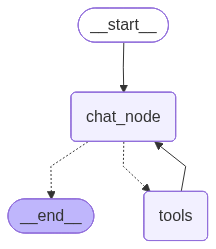

In [28]:
chatbot = graph.compile()
chatbot

In [29]:
# regular chat example
initial_state = {
    'messages': [HumanMessage(content="Hello! Can you help me find the latest news on AI advancements and also calculate the sum of 45.5 and 32.3?")]
}
chatbot.invoke(initial_state)

{'messages': [HumanMessage(content='Hello! Can you help me find the latest news on AI advancements and also calculate the sum of 45.5 and 32.3?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'calculator_tool', 'arguments': '{"second_num": 32.3, "first_num": 45.5, "operation": "add"}'}, '__gemini_function_call_thought_signatures__': {'dd04414c-3b25-40d8-a306-9945cb496a46': 'Cq4EAXLI2ny6j8fA9SnMN1H6+See/eCIbIbmJX3SmtUaRhXfs3CyB7tAWL8uwhAWNryBRD80R/nkFw6xe2l86pcQedj/L2RxkDDkxvqvEf8lh8HijYvTb6sQ7Y7RPUXt9g/vx4worj/PSc2FRmkamd+rYJQ4uHOKuHDhzJq7UQn+AQdvOrGaJPY/m25+oXR4OcMqWe8j5USgx5TqLdiBIa2qaczC92QCoN17bNIsxVTDrsnkU5E8jL5Pn5Jrv2o+xBCMjqhFhS3p7rQAGrPmb4/2VhBuzf9a+WOWjYW0TdKDEpzeC3kkJe4BrBuz3SLEpe1Ft5wGJy+w0w7nba9qqORUVF8N9GP6E7k1SXAvP8uUJKOKJs/Rcpx5TMgAqai+Tl3foGihELxccNjYYRcE/oqkDmj/ZVUnDCjhrYeOxUIcH810ENENVctml4GoNd4y5dxGXrzIpvKEjPEiOtsytsf3FobKUuT1x0z0nCm33qW6FrhQ7TjDbZWmYZgvaMwyDNeKshAhXk3jDqRcVFXEMvALD5hiQt5SzzcEiGSiy7e

In [31]:
initial_state = {
    'messages': [HumanMessage(content="what is stock price for apple?")]
}
output = chatbot.invoke(initial_state)
output["messages"][-1].content

'The stock price for Apple (AAPL) is 259.3700.'